# Resampling & Reshaping Methods
In the y-axis (time), reshaping will be performed by a combination of padding/truncation (to match time ranges of scans) and DFT resampling (to time-align data and reshape all scans to a fixed size vector).

In the x-axis, each scan will be 1 meter wide with a fixed number of scans per meter. Resampling in the x direction will be performed after resampling in the y direction. 

### Select Reshaping Parameters

Examine metadata for real scans to make good choices for sample rate and time range.

In [1]:
from real_data_wrangling.metadata_ifsttar import get_metadata

import h5py
import numpy as np
import math
import boto3
import io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
s3 = boto3.resource('s3')

In [2]:
m = get_metadata()
m.describe()

,center_frequency,profile,range,samples_per_ascan,scan_count,scan_width,scans_per_meter,sample_rate
count,62.000000,62.000000,62.000000,62.000000,62.000000,42.000000,42.000000,6.200000e+01
mean,530.806452,8.403226,87.322581,665.016129,1662.758065,19.112843,94.095238,7.697822e+09
std,262.080568,4.473821,17.842456,239.196160,1155.321411,6.369372,72.705154,2.193913e+09
min,200.000000,1.000000,60.000000,413.000000,474.000000,9.480000,30.000000,3.577586e+09
25%,350.000000,4.250000,70.000000,512.000000,805.750000,12.467500,50.000000,5.606742e+09
50%,400.000000,9.500000,89.000000,512.000000,1342.000000,22.072727,50.000000,8.101124e+09
75%,875.000000,11.750000,100.000000,1024.000000,1860.750000,24.665000,200.000000,1.024000e+10
max,900.000000,15.000000,116.000000,1024.000000,5168.000000,26.260000,200.000000,1.137778e+10


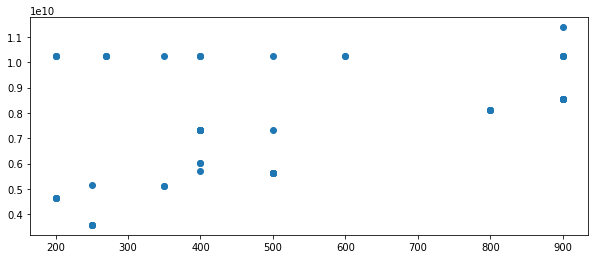

In [3]:
plt.scatter(m['center_frequency'], m['sample_rate'])

Select a low sample rate file to demonstrate resampling.

In [4]:
m[m['sample_rate']/1e9 <= 4]

,center_frequency,id,profile,range,reverse,samples_per_ascan,scan_count,scan_width,scans_per_meter,soil_type,sample_rate
3,250,07ecd2dc-1d04-418e-811a-2a82c22faa15,5,116,True,415,754,22.848485,33.0,gneiss0-20,3.577586e+09
4,250,0d17299a-0441-4fa6-98e8-9aa7637f10ed,15,116,False,415,733,22.212121,33.0,NA,3.577586e+09
32,250,6c70e440-8ca1-41de-b2c5-af574394cbf6,11,116,True,415,737,22.333333,33.0,gneiss14-20,3.577586e+09
53,250,dc56086d-0b79-4055-ba06-62ee23392d6f,13,116,True,415,715,21.666667,33.0,limestone,3.577586e+09


Read data from the hdf5 file.

In [64]:
m.to_csv("real_data_metadata.csv")

In [3]:
def read_scan(id):
    with io.BytesIO() as b:
        s3.Object("jean-masters-thesis", f"gold_data/ifsttar/data/{id}.hdf5").download_fileobj(b)

        with h5py.File(b, 'r') as f:
            d = np.zeros(f['data'].shape, dtype=float)
            f['data'].read_direct(d)
    return d

In [5]:
with io.BytesIO() as b:
    s3.Object("jean-masters-thesis", "gold_data/ifsttar/data/dc56086d-0b79-4055-ba06-62ee23392d6f.hdf5").download_fileobj(b)

    with h5py.File(b, 'r') as f:
        d = np.zeros(f['data'].shape, dtype=float)
        f['data'].read_direct(d)

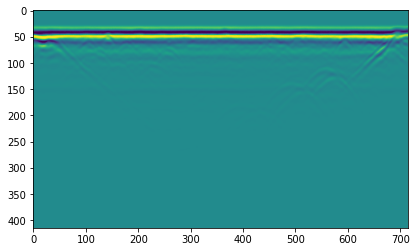

In [61]:
plt.imshow(d)

### Selecting and Labeling Scans

In [45]:
m['soil_type'].value_counts()

silt           16
gneiss0-20     15
gneiss14-20    15
limestone      12
NA              4
Name: soil_type, dtype: int64

In [51]:
m[m['profile'] == 11]

,center_frequency,id,profile,range,reverse,samples_per_ascan,scan_count,scan_width,scans_per_meter,soil_type,sample_rate
6,900,15ddf7dd-7cf7-4cb5-91f2-8ce208098897,11,90,False,1024,4952,24.760000,200.0,gneiss14-20,1.137778e+10
9,400,261fbfdd-38a3-44c3-b4f5-ff1b99faa2d2,11,90,True,512,639,21.300000,30.0,gneiss14-20,5.688889e+09
12,200,2bc1088f-21b3-4f54-a083-668c277ff915,11,110,True,512,1291,25.820000,50.0,gneiss14-20,4.654545e+09
14,500,32276cf2-9854-4f96-81fb-6490e3153c9d,11,89,True,499,1287,25.740000,50.0,gneiss14-20,5.606742e+09
16,500,33ec8c3b-e8ce-4245-90ee-e08c160cfb0a,11,100,False,1024,4838,24.190000,200.0,gneiss14-20,1.024000e+10
19,400,3e5126cf-5dcc-4438-a1f0-3e41cd0e63ef,11,100,False,1024,2462,24.620000,100.0,gneiss14-20,1.024000e+10
31,350,67cc56a0-4820-4719-9073-10350bed7a81,11,100,False,1024,5168,25.840000,200.0,gneiss14-20,1.024000e+10
32,250,6c70e440-8ca1-41de-b2c5-af574394cbf6,11,116,True,415,737,22.333333,33.0,gneiss14-20,3.577586e+09
39,270,8b4d6cf5-7431-4876-8e6d-464d0fdd4532,11,100,False,1024,4775,23.875000,200.0,gneiss14-20,1.024000e+10
41,800,91da0bfe-dbb8-45ff-a226-1b1252b802af,11,89,True,721,820,24.848485,33.0,gneiss14-20,8.101124e+09


In [409]:
s = read_scan('32276cf2-9854-4f96-81fb-6490e3153c9d')

In [410]:
s.shape

(499, 1287)

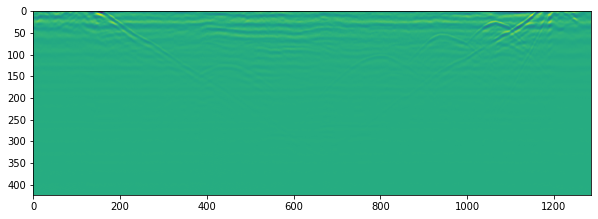

In [412]:
plt.imshow(s[75:,:])

## plt.imshow(s[100:400])

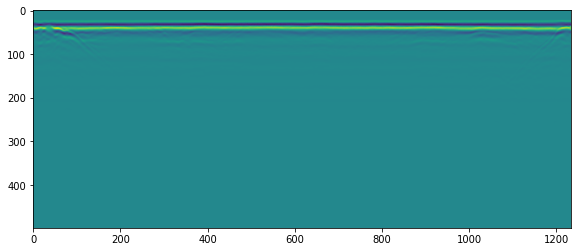

In [66]:
plt.imshow(s)

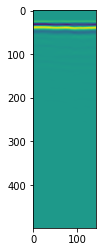

In [63]:
plt.imshow(s[:, 400:544])

### Resampling Along Time Axis
Use a discrete Fourier transform, shift, pad, and inverse Fourier transform to resample the input wave form. All input wave forms will be resampled so that they are 120 ns long with a sample rate of 10 samples/ns. Each output wave form will be a vector of 1200 elements.

In [4]:
from real_data_wrangling.reshape import dft_resample, resample_y

In [5]:
output_time_range = 120
sample_rate = 10 # samples per ns

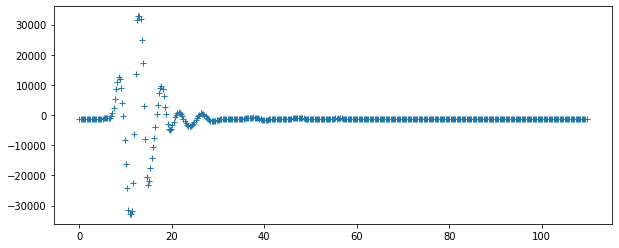

In [6]:
input_time_range = 110
y = d[:, 0]
t = np.arange(0, input_time_range, input_time_range / len(y))

plt.plot(t, y, '+')

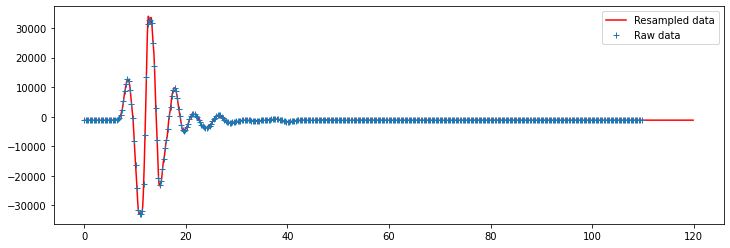

In [7]:
y_resampled = dft_resample(y, input_time_range, sample_rate, output_time_range)
t_resampled = np.arange(0, output_time_range, 1 / sample_rate)

with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(t_resampled, y_resampled, 'r')
    ax.plot(t, y, '+')
    ax.legend(['Resampled data', 'Raw data'])

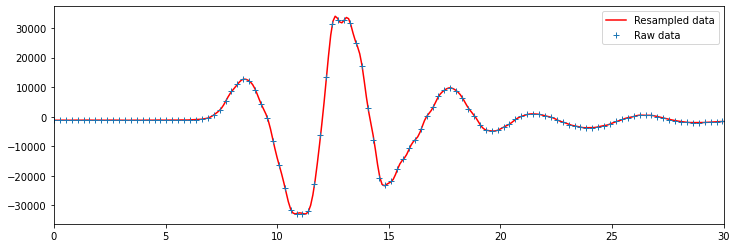

In [8]:
with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(t_resampled, y_resampled, 'r')
    ax.plot(t, y, '+')
    ax.legend(['Resampled data', 'Raw data'])
    ax.set_xlim(0, 30)

Risk: upsampling creates aliased waveform

Apply resampling method to all a-scans (columns) of the input data.

In [9]:
resampled_scan = resample_y(d, input_time_range, sample_rate, output_time_range)

Comparison of raw and resampled scans.

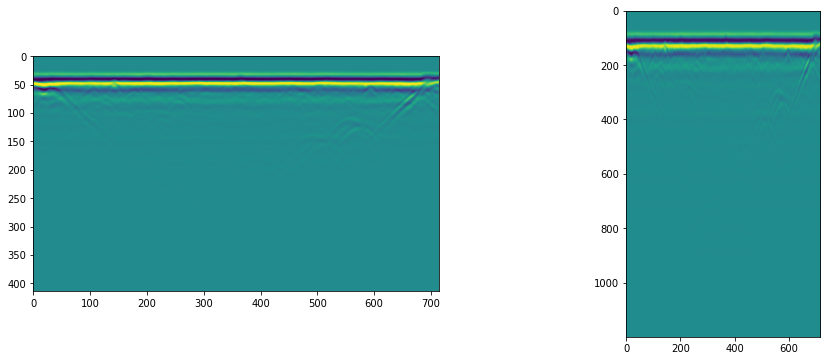

In [10]:
with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.imshow(resampled_scan)

## Resampling Along Distance Axis
Since shapes manifest themselves as parabolic curves, use second order polynomial interpolation to upsample the input scans along the x-axis.

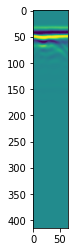

In [11]:
scans_per_m = 33
meters = 2
scans_per_m_output = 50

# Select 2 m worth of scans
s = d[:,0:scans_per_m * meters]
plt.imshow(s)

In [12]:
from real_data_wrangling.reshape import polynomial_resample, linear_resample

In [13]:
x = d[0, 0:scans_per_m * meters]
m = np.linspace(0, meters, scans_per_m * meters)

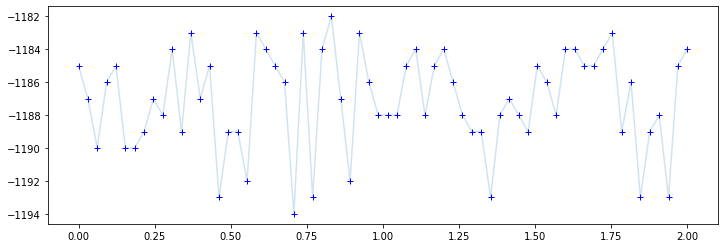

In [14]:
with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(m, x, alpha=0.2)
    ax.plot(m, x, 'b+')

In [15]:
x_resampled = polynomial_resample(x, meters, scans_per_m_output * meters)
m_resampled = np.linspace(0, meters, scans_per_m_output * meters)

Hypothesis busted? Seems like maybe polynomial resampling won't work here.

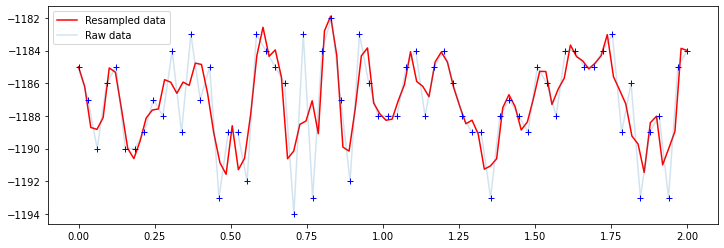

In [16]:
with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(m_resampled, x_resampled, 'r')
    ax.plot(m, x, alpha=0.2)
    ax.plot(m, x, 'b+')
    ax.legend(['Resampled data', 'Raw data'])

Linear resampling looks much better.

In [17]:
x_resampled = linear_resample(x, meters, scans_per_m_output * meters)
m_resampled = np.linspace(0, meters, scans_per_m_output * meters)

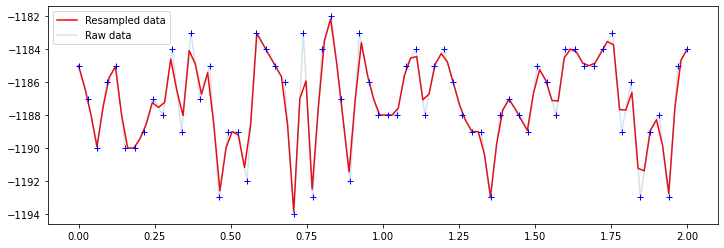

In [18]:
with plt.rc_context({'figure.figsize': [12, 4]}):
    fig, ax = plt.subplots()
    ax.plot(m_resampled, x_resampled, 'r')
    ax.plot(m, x, alpha=0.2)
    ax.plot(m, x, 'b+')
    ax.legend(['Resampled data', 'Raw data'])

Apply linear resampling to all rows of the dataset.

In [19]:
from real_data_wrangling.reshape import resample_x

In [20]:
meters_scan = d.shape[1] / scans_per_m
resampled_scan_xy = resample_x(resampled_scan, meters_scan, math.floor(scans_per_m_output * meters_scan))

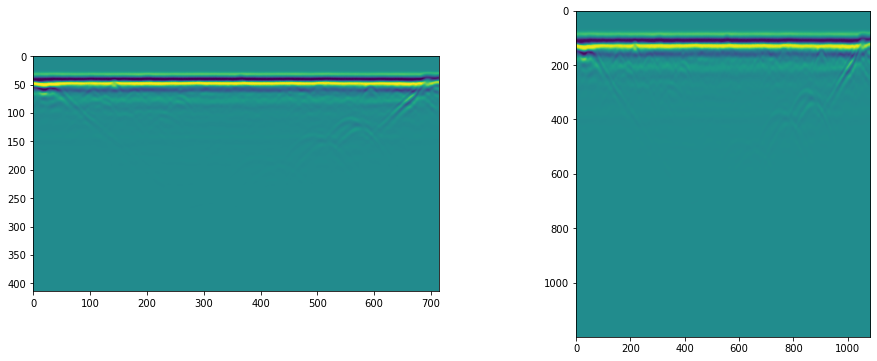

In [21]:
with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.imshow(resampled_scan_xy)

#### Combine x and y Resampling into a Single Function

In [22]:
from real_data_wrangling.reshape import resample_xy

In [23]:
r = resample_xy(d, input_time_range, sample_rate, output_time_range, meters_scan, 
                math.floor(scans_per_m_output * meters_scan))

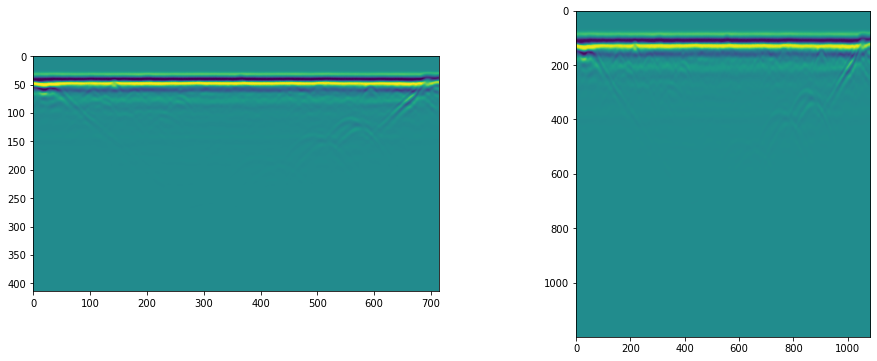

In [24]:
with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.imshow(r)

## Slicing Scans to Fixed Size Matrices
Use a sliding window to generate a large number of 2m-wide scans. This will fix the input size of the NN input layer.

In [25]:
window_size = 2 * 50
n_steps = r.shape[1] - window_size + 1

sliced_scans = [r[:, n:n + window_size] for n in range(n_steps)]

len(sliced_scans)

984

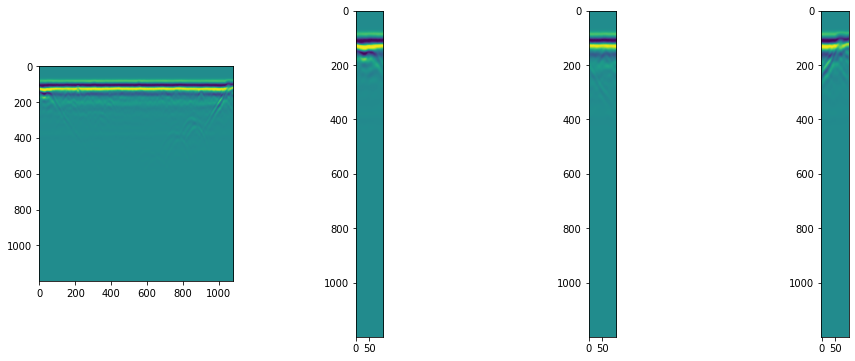

In [26]:
with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    ax1.imshow(r)
    ax2.imshow(sliced_scans[0])
    ax3.imshow(sliced_scans[100])
    ax4.imshow(sliced_scans[-1])

## Preprocessing Summary
Combine all of the above operations into a single function that can be used to preprocess all input scans.

In [27]:
from real_data_wrangling.reshape import preprocess_scan

In [28]:
help(preprocess_scan)

Help on function preprocess_scan in module real_data_wrangling.reshape:

preprocess_scan(data, input_time_range, output_sample_rate, output_time_range, x_range, output_size, window_size)
    Pre-processes the b-scan represented by the provided data to prepare it for use as input to a neural network. The
    provided data is resampled in both the x and y directions according to the parameters provided. Resampling is
    performed first in the y-direction using a DFT resampling method along with padding or truncation is needed.
    Next, the data is resampled in the x direction using linear interpolatio so that all scans are transformed to
    include the same number of samples per meter. The resulting scan is then sliced using a sliding window to
    generate a large number of shorter scans according to the provided window_size. The shape of each slice in the
    output data is (output_sample_rate * output_time_range, window_size).
    
    :param data: 2D matrix of data to be resampled

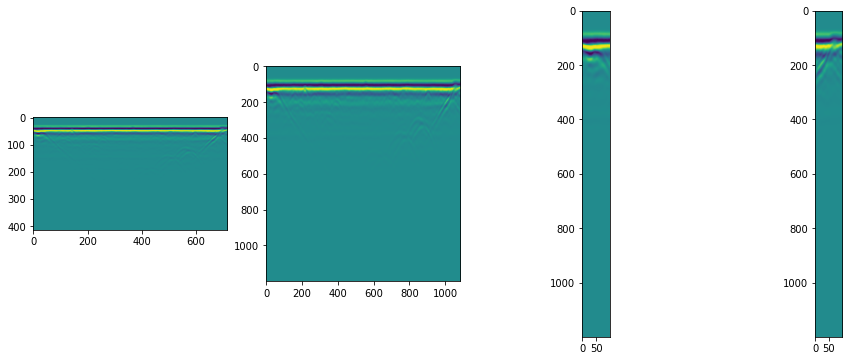

In [29]:
p = preprocess_scan(
    d, input_time_range, sample_rate, output_time_range, meters_scan, math.floor(scans_per_m_output * meters_scan), 
    window_size
)

with plt.rc_context({'figure.figsize': [16, 6]}):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    ax1.imshow(d)
    ax2.imshow(r)
    ax3.imshow(p[0])
    ax4.imshow(p[-1])

## Noise Addition Methods

In [1]:
import numpy as np

#### Gaussian Noise
Base parameters of distribution off of noise in real GPR data.

In [2]:
from real_data_wrangling.clean_gulkana import read_gulkana, gulkana_time_windows, preprocess_gulkana_real_data

In [3]:
X, y = preprocess_gulkana_real_data(prefix="DATA01/LINE00")

Processing raw_data/gulkanaGlacier_rawGPR_2017/GPR_data/DATA01/LINE00.DT1
[preprocess_scan] data.shape = (1000, 9228)
Shape of unsliced scan (480, 46135)
len(bootstrapped_scans) = 466


In [4]:
time_window = gulkana_time_windows(prefix="DATA01/LINE00")

In [5]:
t = np.linspace(0, 120, 480)
t.shape

(480,)

In [6]:
X.shape

(466, 100, 480)

In [7]:
import matplotlib.pyplot as plt

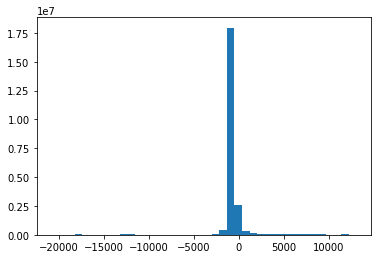

In [8]:
plt.hist(X.flatten(), bins=40);

Removing outliers, the signal values roughly follow a normal distribution with mean -679 and standard deviation 388.

In [9]:
vals = [x for x in X.flatten() if -2000 < x < 2000]

In [10]:
np.mean(vals), np.std(vals)

(-701.6853418785341, 360.22376343374333)

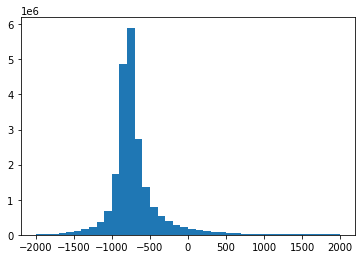

In [11]:
plt.hist(vals, bins=40);

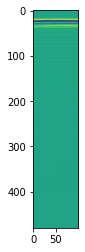

In [12]:
plt.imshow(X[0,:,:].T)

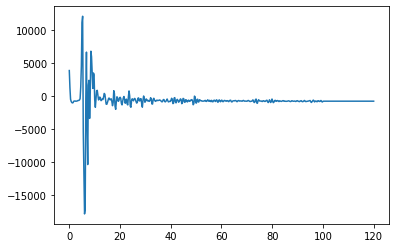

In [13]:
plt.plot(t, X[0,0,:])

Apply a highpass filter to each A-scan to filter out the signal and keep the noise.

In [14]:
from scipy.signal import butter, lfilter, freqz

In [15]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [16]:
def extract_noise(ascan, cutoff):
    # Filter requirements.
    order = 6
    fs = 30.0   # sample rate, Hz

    return butter_highpass_filter(ascan, cutoff, fs, order)


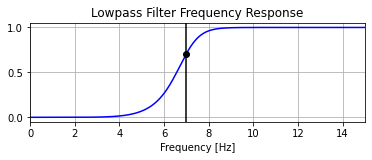

In [17]:
# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 7  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_highpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [18]:
real = X[0,:,:]
real.shape

(100, 480)

In [19]:
def normalize_scan(scan):
    return (scan - np.min(scan)) / (np.max(scan) - np.min(scan))

In [20]:
real_normalized = normalize_scan(real)
real_normalized.shape

(100, 480)

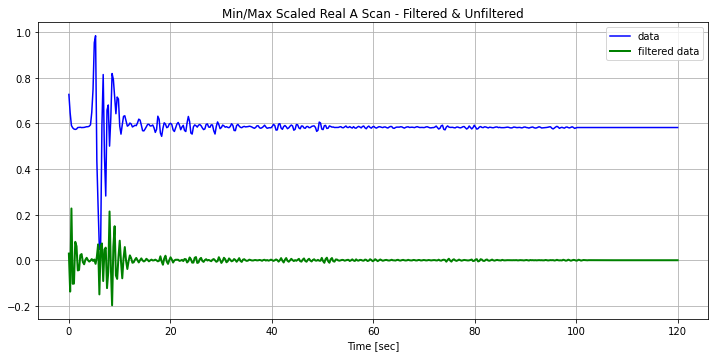

In [21]:
# Filter the data, and plot both the original and filtered signals.
noise = extract_noise(real_normalized[0,:], 7)

with plt.rc_context({'figure.figsize': [12, 12]}):
    plt.subplot(2, 1, 2)
    plt.plot(t, real_normalized[0,:], 'b-', label='data')
    plt.plot(t, noise, 'g-', linewidth=2, label='filtered data')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()
    plt.title('Min/Max Scaled Real A Scan - Filtered & Unfiltered')

Clip noise at 75% magnitude.

In [22]:
np.percentile(y, 97)

0.0

In [23]:
def extract_noise(ascan, cutoff, percentile=100):
    # Filter requirements.
    order = 6
    fs = 30.0   # sample rate, Hz

    y = butter_highpass_filter(ascan, cutoff, fs, order)
    c = np.percentile(np.abs(y), percentile)
    return np.clip(y, -c, c)

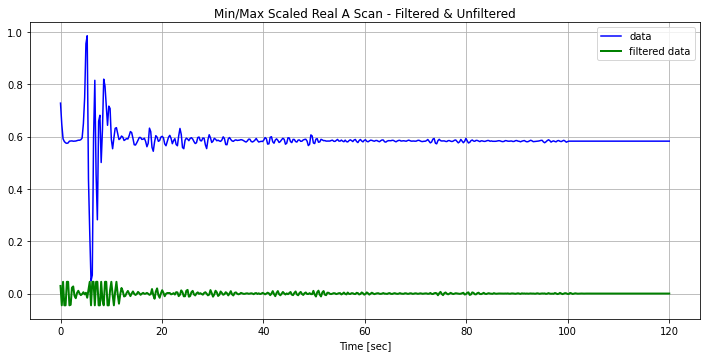

In [24]:
noise = extract_noise(real_normalized[0,:], 7, percentile=95)

with plt.rc_context({'figure.figsize': [12, 12]}):
    plt.subplot(2, 1, 2)
    plt.plot(t, real_normalized[0,:], 'b-', label='data')
    plt.plot(t, noise, 'g-', linewidth=2, label='filtered data')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()
    plt.title('Min/Max Scaled Real A Scan - Filtered & Unfiltered')

In [25]:
def extract_noise_bscan(scan, cutoff, percentile=100):
    # Each column of the input matrix should represent an ascan
    
    return np.apply_along_axis(extract_noise, 0, scan, cutoff, percentile)

Read in a simulated scan for comparison.

In [26]:
from labeling import S3DataLoader

In [27]:
sim = S3DataLoader.load_scan('jean-masters-thesis', 'simulations/merged/626_merged.csv')
sim = sim.T[:,:100]

In [28]:
from preprocessing import resample_scan
# Reshaping parameters
output_time_range = 120
sample_rate = 4  # samples per ns

In [29]:
resampled_sim = resample_scan(sim, sample_rate, output_time_range)
normalized_sim = normalize_scan(resampled_sim)

## Resampled Real & Simulated Scans

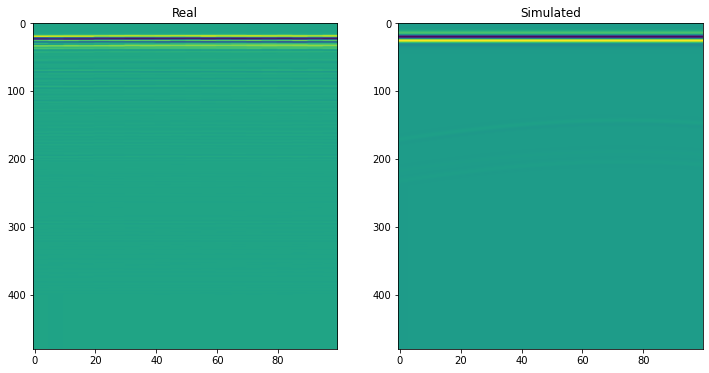

In [30]:
with plt.rc_context({'figure.figsize': [12, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(real.T, aspect='auto')
    ax1.set_title('Real')
    ax2.imshow(resampled_sim, aspect='auto')
    ax2.set_title('Simulated')

## Resampled & Normalized

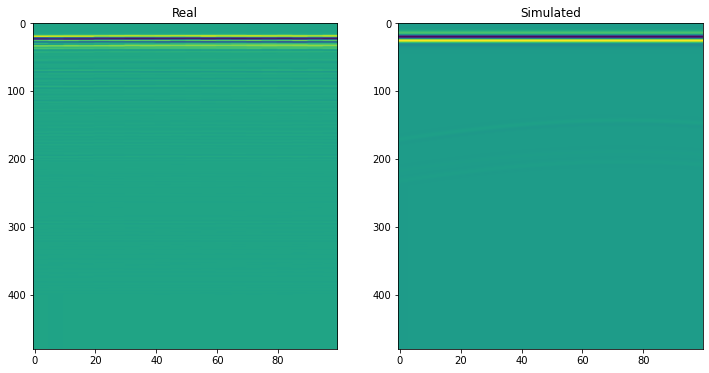

In [31]:
with plt.rc_context({'figure.figsize': [12, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(normalize_scan(real.T), aspect='auto')
    ax1.set_title('Real')
    ax2.imshow(normalize_scan(resampled_sim), aspect='auto')
    ax2.set_title('Simulated')

## Extract Noise from B-Scan

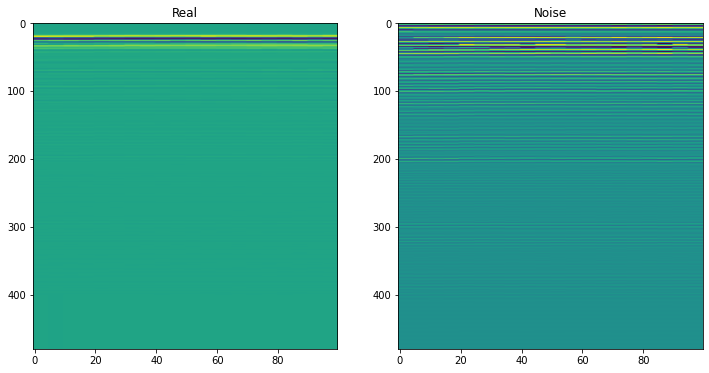

In [32]:
with plt.rc_context({'figure.figsize': [12, 6]}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(normalize_scan(real.T), aspect='auto')
    ax1.set_title('Real')
    ax2.imshow(extract_noise_bscan(normalize_scan(real.T), 5, 95), aspect='auto')
    ax2.set_title('Noise')

## Apply Noise to Simulated B-Scan

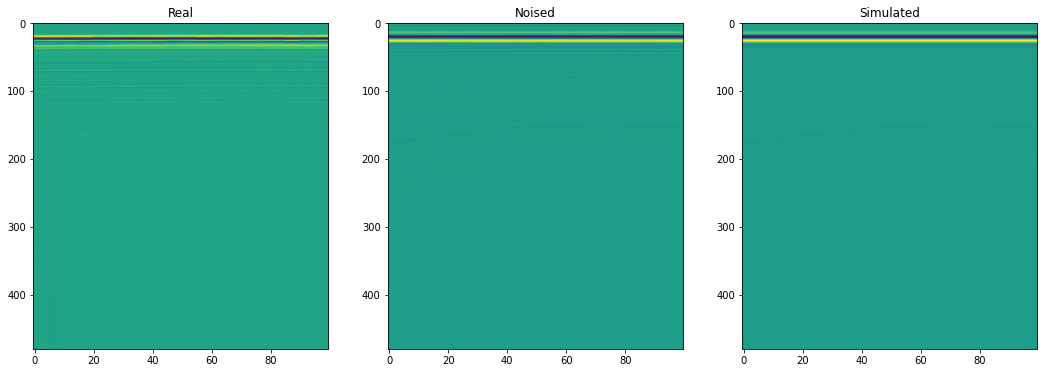

In [33]:
with plt.rc_context({'figure.figsize': [18, 6]}):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(normalize_scan(real.T), aspect='auto')
    ax1.set_title('Real')
    ax2.imshow(normalize_scan(resampled_sim) + extract_noise_bscan(normalize_scan(real.T), 5, 95), aspect='auto')
    ax2.set_title('Noised')
    ax3.imshow(normalize_scan(resampled_sim), aspect='auto')
    ax3.set_title('Simulated')

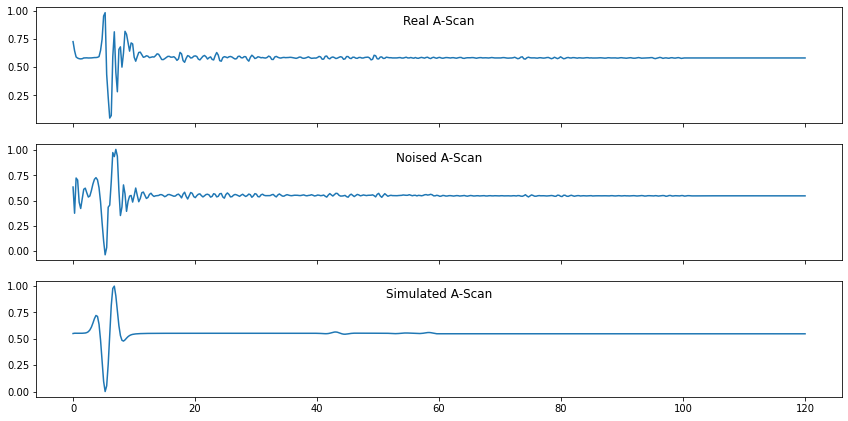

In [34]:
with plt.rc_context({'figure.figsize': [12, 6]}):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.tight_layout()
    ax1.plot(t, real_normalized[0,:])
    ax1.set_title('Real A-Scan', y=.8)
    ax2.plot(t, normalized_sim[:,0] + extract_noise(real_normalized[0,:], 5, 99))
    ax2.set_title('Noised A-Scan', y=.8)
    ax3.plot(t, normalized_sim[:,0])
    ax3.set_title('Simulated A-Scan', y=.8)


In [35]:
from preprocessing import Noiser

In [ ]:
noiser = Noiser(5, 99)

Processing raw_data/gulkanaGlacier_rawGPR_2017/GPR_data/DATA02/LINE00.DT1
[preprocess_scan] data.shape = (1000, 65272)
Shape of unsliced scan (480, 326355)
len(bootstrapped_scans) = 3296
Processing raw_data/gulkanaGlacier_rawGPR_2017/GPR_data/DATA02/LINE01.DT1
[preprocess_scan] data.shape = (1000, 77785)
Shape of unsliced scan (480, 388919)
len(bootstrapped_scans) = 3928
Processing raw_data/gulkanaGlacier_rawGPR_2017/GPR_data/DATA02/LINE02.DT1
[preprocess_scan] data.shape = (1000, 57513)
Shape of unsliced scan (480, 287560)
len(bootstrapped_scans) = 2904
Processing raw_data/gulkanaGlacier_rawGPR_2017/GPR_data/DATA02/LINE03.DT1


In [ ]:
noised = noiser.noise(resampled_sim)
imshow(noised, aspect="auto")